# Modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Data structure:

- input shape: (1239 x 29), where shape[0] is number of samples and shape[1] is number of features in the input space
- output shape: (1239 x 7), where shape[0] is number of samples and shape[1] is number of output/target elements

It is important to scale input in range of (0, 1), for example by using MinMaxScaler in sklearn package.
The code below is prepared for tensorflow, however, it can easily be used for any other package.

# 0-1 Importance

## General plot

In [2]:
# Path to a folder containing model .h5 file (architecture, weights and biases) and data
folder_path = 'C:/Users/kamil/Dropbox (The University of Manchester)/KTP/Work/Data/Models/Yongwen/'

# load pre-trained model
model = keras.models.load_model(folder_path + 'model.h5', compile = False)

# Huber loss function sometimes does not load properly from .h5 file, so you need to compile it manually
model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber())

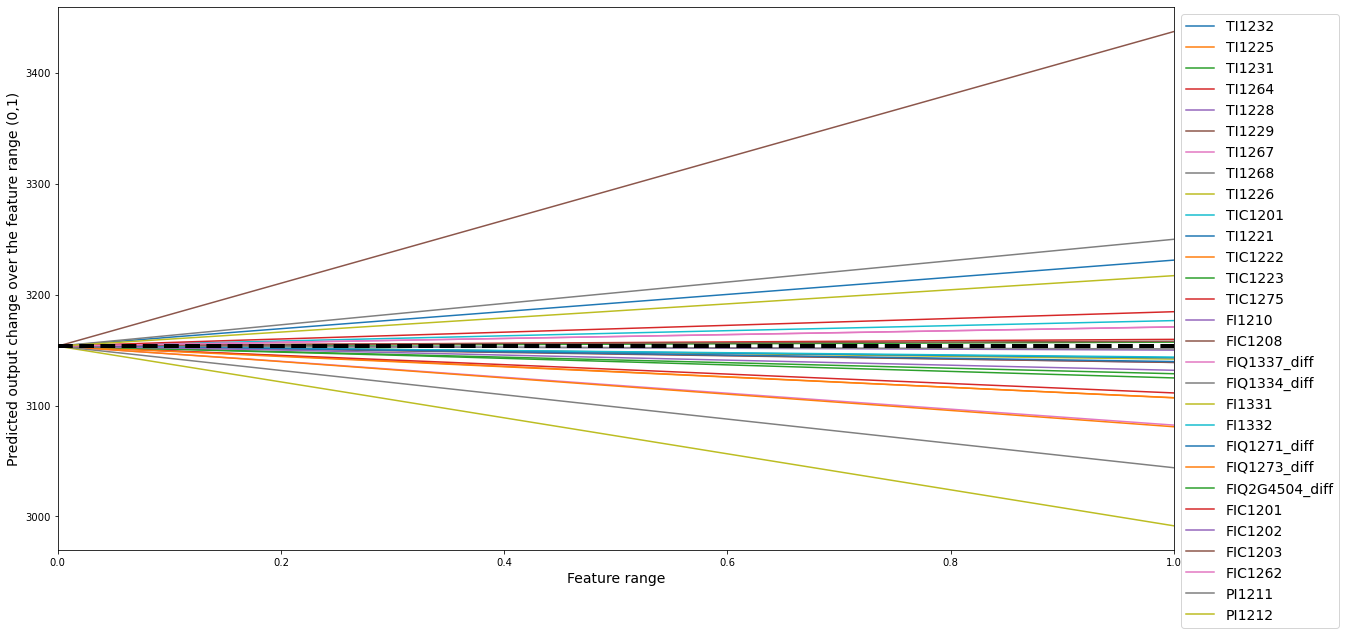

In [3]:
# load your data from .npz file, and split into training and testing set
# the data were scaled before training and saved, so you do not need to pre-process them. Just load and use.
data = np.load(folder_path + 'data.npz')
X = np.array(data['X'])
y = np.array(data['y'])
columns = np.array(data['columns'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


# Range of values for features. 
# That is why it is important to have data scaled between 0 and 1, so you can create a linear vector.
fix = np.arange(0, 1.01, 0.01)

# y_pred will contain all feature importances
y_pred = np.zeros((len(fix), X.shape[1]))


# X.shape[1] - looping through all feature (29 in this case)
for i in range(0, X.shape[1]):

    # Selecting the actual feature for analysis
    X = np.array(data['X'])[0, :].reshape(1, 29)

    # Assigning all features except the one above (under analysis) to 0.
    X[0, :] = 0
    
    # Then loop through fix variable to calculate feature importance of the above feature between 0 and 1 of its values.
    for j, value in enumerate(fix):
        X[0, i] = value
        
        # Prediction of the output with pre-loaded model on the artificially created input X, with only one non-zero value.
        # In this case, there is 7 outputs. TO generalise, a sum of absolute values is taken as the feature importance. 
        y_pred[j, i] = np.sum(np.abs(model.predict(X)[0]))

# plotting the results. What we actually are calculating, how is the output prediction changing for a single value of input
# vector from 0 to 1. Higher change - more important.
for i in range(0, y_pred.shape[1]):
    plt.plot(fix, y_pred[:, i], label = columns[i])
    plt.ylabel('Predicted output change over the feature range (0,1)', size = 14)
    
plt.xlim(0, 1)

# when X is all zeros - it gives a BASELINE.
plt.axhline(y_pred[0, 0], lw = 4, color = 'black', ls = '--')
plt.xlabel('Feature range', size = 14)
plt.legend(fontsize = 14, bbox_to_anchor=(1, 1), loc='upper left')    
plt.show()

## Normalisation to baseline

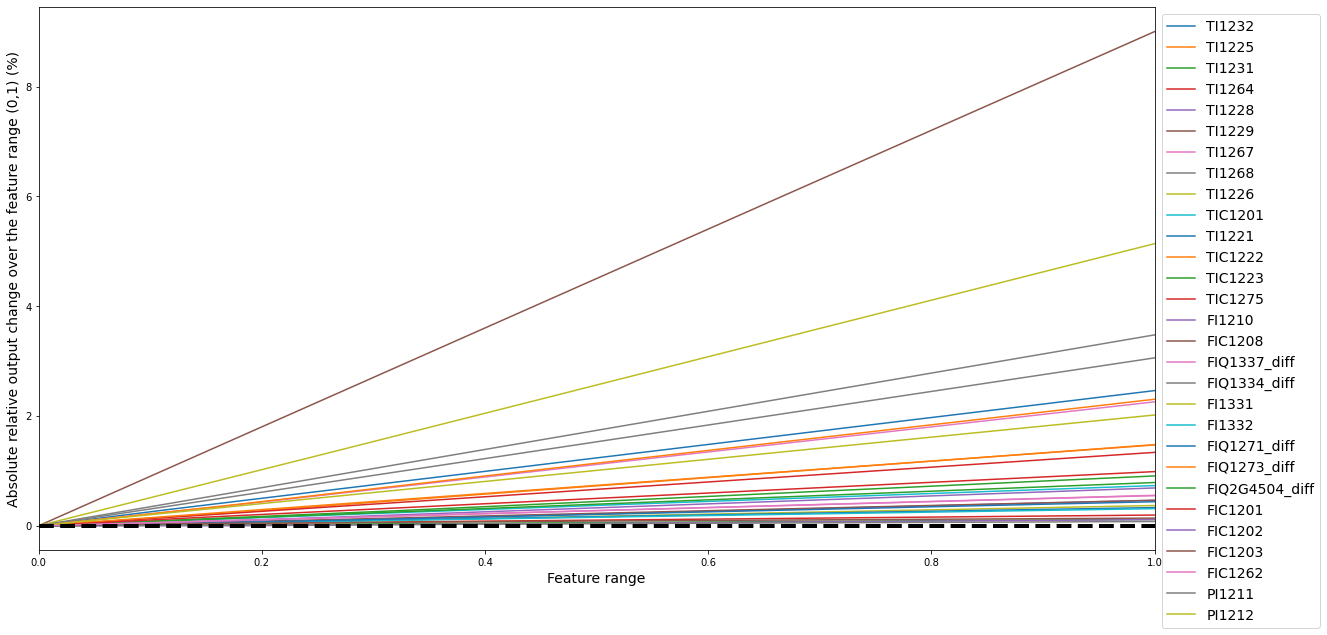

In [4]:
# Some features make negative and some make positive prediction. To compare them, you can take their absolute values.
# Then normalise against the baseline determine above: np.abs((y_pred[:, i] / y_pred[0, i]) * 100 - 100)
# So effectively, you get a % change from X zeros to X = 1 for each feature.
# Again - higher change means higher importance.
for i in range(0, y_pred.shape[1]):
    plt.plot(fix, np.abs((y_pred[:, i] / y_pred[0, i]) * 100 - 100), label = columns[i])
    plt.ylabel('Absolute relative output change over the feature range (0,1) (%)', size = 14)
    
plt.xlim(0, 1)
plt.axhline(0, lw = 4, color = 'black', ls = '--')
plt.xlabel('Feature range', size = 14)
plt.legend(fontsize = 14, bbox_to_anchor=(1, 1), loc='upper left')    
plt.show()

## Maximum point importance

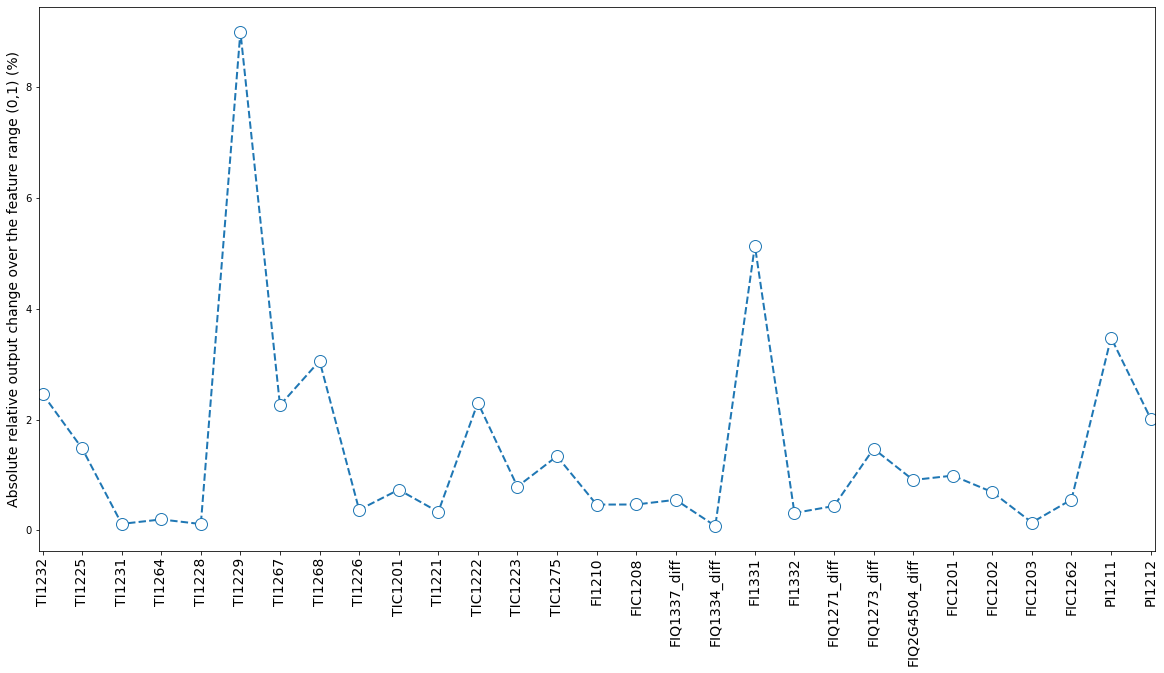

In [5]:
# You can take the maximum % change from the above, and plot it against the feature labels.
# Those with higher values - higher importance.
# IN some cases - particuarly deep network, the above importance can have non-linear behaviour against their X = (0, 1).
# It seems reasonable, to take their maximum value (which may not always be at X = 1)
y_pred_norm = np.max(np.abs(y_pred / y_pred[0, 0] * 100 - 100), axis = 0)

plt.plot(columns, np.abs(y_pred_norm), linestyle = '--', marker = 'o', lw = 2, mfc = 'white', ms = 12)
plt.ylabel('Absolute relative output change over the feature range (0,1) (%)', size = 14)
plt.xticks(size = 14, rotation = 90)
plt.xlim(-.1, len(columns)-.9)

plt.show()

## Maximum point importance sorted

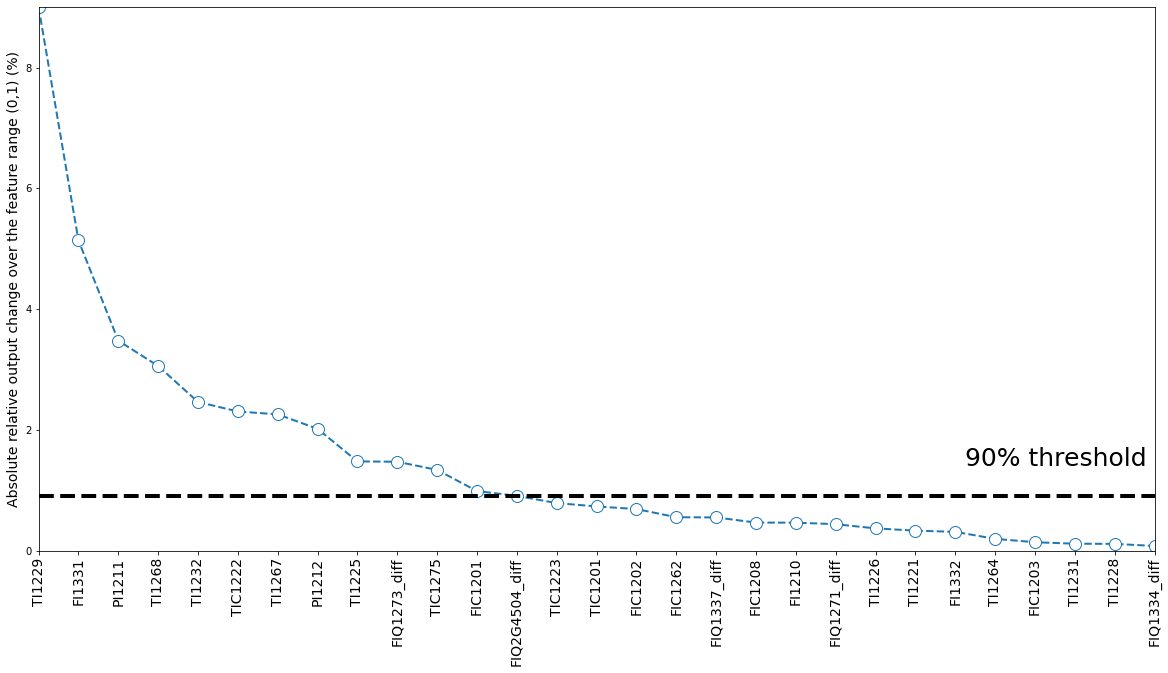

In [6]:
# You can sort the importances from the highest to the lowest. And to perform feature selection, you can set a threshold.
# FOr example threshold = 90% means that from the maximum importance (in this case around 9%), 90% of that will be set
# to accept for the model, and the rest (below the threshold) refused. THis needs to be tested, though.

columns_sorted = np.argsort(y_pred_norm)[::-1]
y_pred_norm_sorted = np.sort(y_pred_norm)[::-1]

plt.plot(columns[columns_sorted], y_pred_norm_sorted, linestyle = '--', marker = 'o', lw = 2, mfc = 'white', ms = 12)
plt.xticks(size = 14, rotation = 90)
plt.axhline(0.1 * np.max(y_pred_norm), lw = 4, color = 'black', ls = '--')
plt.ylabel('Absolute relative output change over the feature range (0,1) (%)', size = 14)
plt.text(28, 0.1 * np.max(y_pred_norm) + 0.5,'90% threshold ',horizontalalignment='right', fontsize = 25)
plt.ylim(0, np.max(y_pred_norm))
plt.xlim(0, len(y_pred_norm)-1)
plt.show()